In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime as dt

from statsmodels.tools.eval_measures import rmse 
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.exponential_smoothing.ets import ETSModel
from statsmodels.tsa.arima_model import ARIMA

from pmdarima import auto_arima

In [3]:
df=pd.read_csv('Kaggle traffic.csv')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48120 entries, 0 to 48119
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   DateTime  48120 non-null  object
 1   Junction  48120 non-null  int64 
 2   Vehicles  48120 non-null  int64 
 3   ID        48120 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 1.5+ MB


In [6]:
df['DateTime']=pd.to_datetime(df['DateTime']) # to_datetime이후에 할당을 해주지 않으면 반영이 안됨/ inplace가 없음

In [7]:
for num,i in enumerate(df['DateTime']):
    new_date=i.replace(hour=0)
   #new_date = dt.strptime(i,'%Y-%m-%d ')
    df['DateTime'][num] = new_date   

df['DateTime']

C:\Users\samsung\AppData\Local\Temp\ipykernel_31116\2777894337.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['DateTime'][num] = new_date


0       2015-11-01
1       2015-11-01
2       2015-11-01
3       2015-11-01
4       2015-11-01
           ...    
48115   2017-06-30
48116   2017-06-30
48117   2017-06-30
48118   2017-06-30
48119   2017-06-30
Name: DateTime, Length: 48120, dtype: datetime64[ns]

In [8]:
df=df.drop(labels=['Junction','ID'],axis=1)
df

,DateTime,Vehicles
0,2015-11-01,15
1,2015-11-01,13
2,2015-11-01,10
3,2015-11-01,7
4,2015-11-01,9
...,...,...
48115,2017-06-30,11
48116,2017-06-30,30
48117,2017-06-30,16
48118,2017-06-30,22


In [11]:
df=df.groupby(by='DateTime').mean() 
df

,Vehicles
DateTime,
2015-11-01,8.277778
2015-11-02,12.625000
2015-11-03,12.652778
2015-11-04,11.361111
2015-11-05,10.694444
...,...
2017-06-26,30.791667
2017-06-27,38.635417
2017-06-28,37.281250


In [27]:
df.columns=['traffic']
df

,traffic
DateTime,
2015-11-01,8.277778
2015-11-02,12.625000
2015-11-03,12.652778
2015-11-04,11.361111
2015-11-05,10.694444
...,...
2017-06-26,30.791667
2017-06-27,38.635417
2017-06-28,37.281250


<AxesSubplot:xlabel='DateTime'>

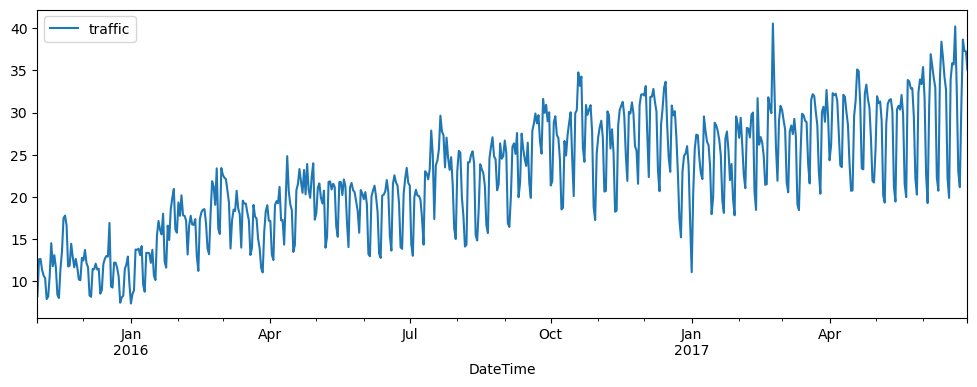

In [28]:
df.plot(figsize=(12,4))

<AxesSubplot:xlabel='DateTime'>

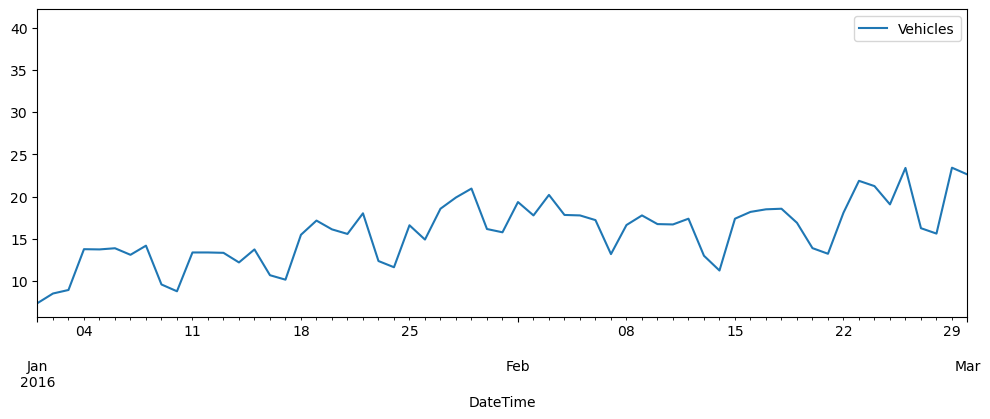

In [18]:
df.plot(figsize=(12,4),xlim=('2016-01-01','2016-03-01'))

* 확대해서 보니 1주일의 계절성을 갖는 것처럼 보인다
<br>
&rightarrow; 주말에 교통량이 확 줄어드는 모습<br>  
&rightarrow; 이는 clear한 seasonality를 갖는다고 볼 수 있다

In [104]:
from statsmodels.tsa.seasonal import seasonal_decompose

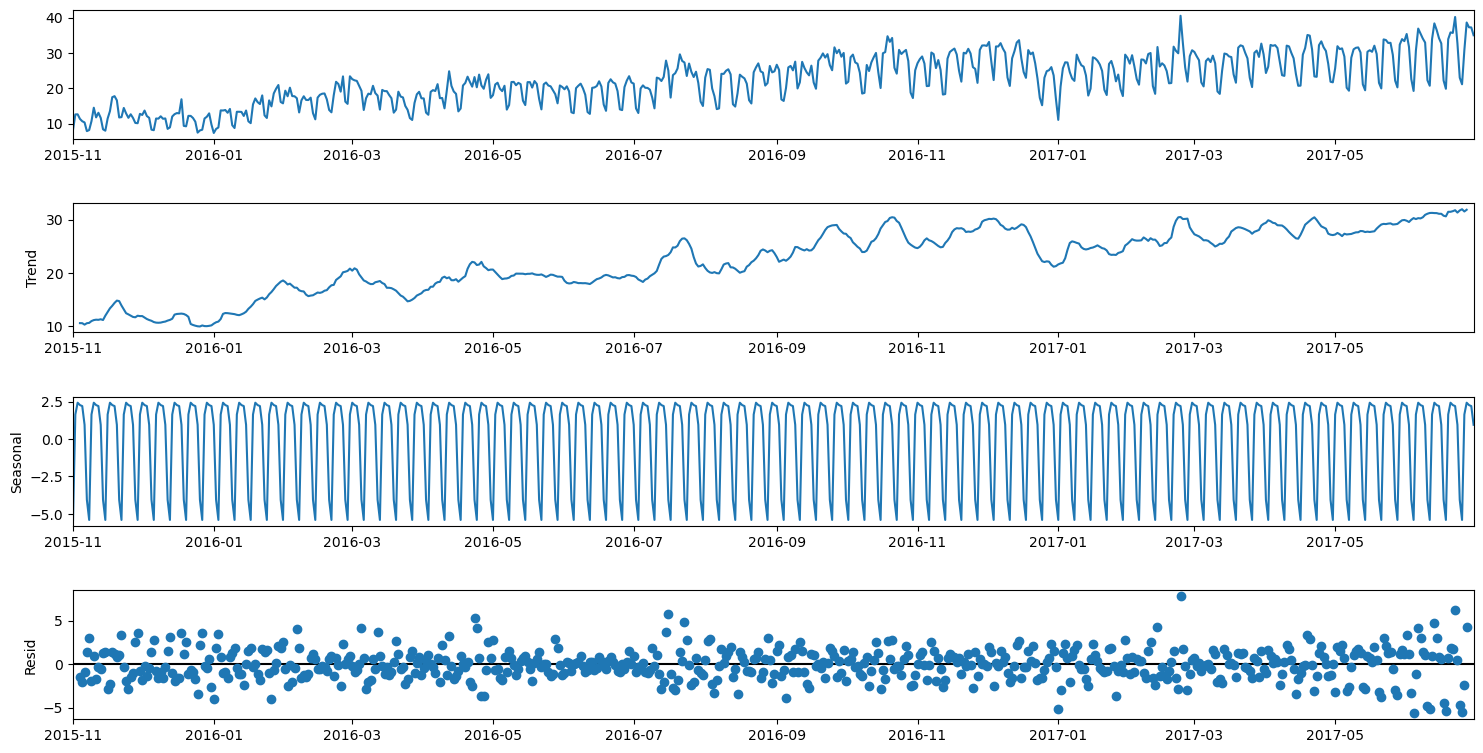

In [117]:
seasonality = seasonal_decompose(df)
fig = seasonality.plot();
fig.set_size_inches(16,8) # seasonal decompose 사이즈 조절

# 먼저 Holt-Winters 기법으로 예측

In [41]:
train_set = df[:-24]
test_set = df[-24:]

model = ExponentialSmoothing(train_set,trend='add',
                             seasonal='mul',seasonal_periods=7,freq='d').fit()

In [42]:
train_set

,traffic
DateTime,
2015-11-01,8.277778
2015-11-02,12.625000
2015-11-03,12.652778
2015-11-04,11.361111
2015-11-05,10.694444
...,...
2017-06-02,31.739583
2017-06-03,22.635417
2017-06-04,19.270833


In [30]:
forecast = model.predict(start = test_set.index[0],end = test_set.index[-1])
forecast

2017-06-07    35.338731
2017-06-08    35.401126
2017-06-09    33.589608
2017-06-10    26.651649
2017-06-11    24.766868
2017-06-12    34.784510
2017-06-13    35.685655
2017-06-14    35.647687
2017-06-15    35.710242
2017-06-16    33.882540
2017-06-17    26.883786
2017-06-18    24.982321
2017-06-19    35.086733
2017-06-20    35.995324
2017-06-21    35.956644
2017-06-22    36.019358
2017-06-23    34.175473
2017-06-24    27.115924
2017-06-25    25.197775
2017-06-26    35.388957
2017-06-27    36.304992
2017-06-28    36.265600
2017-06-29    36.328474
2017-06-30    34.468405
Freq: D, dtype: float64

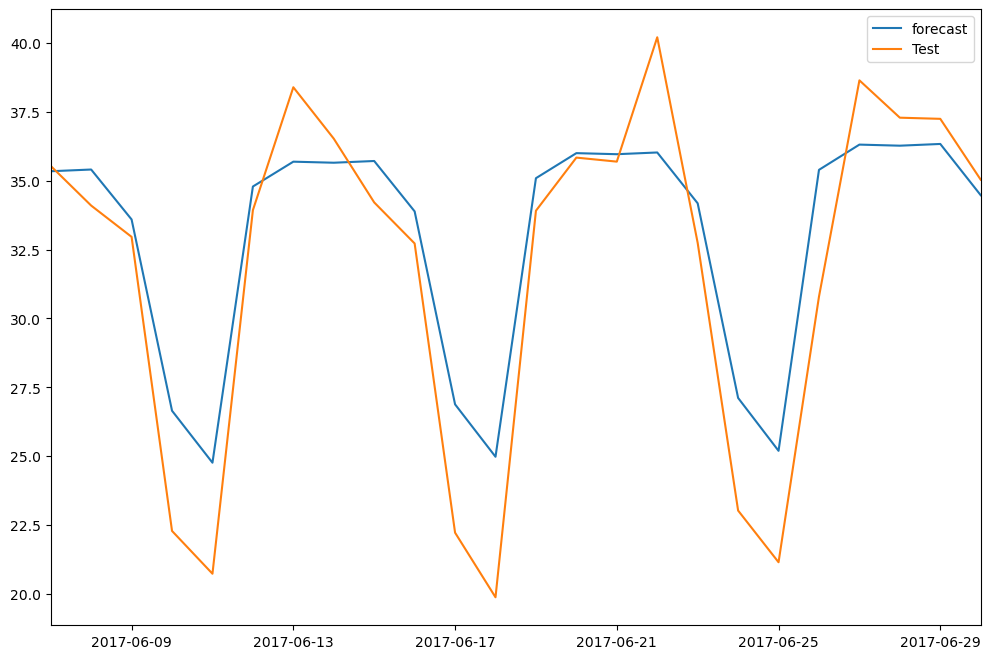

In [32]:
start = test_set.index[0]
end = test_set.index[-1]
plt.figure(figsize=(12,8))
plt.xlim(start,end)

plt.plot(pd.date_range(start=test_set.index[0],periods=24),forecast,label='forecast')
plt.plot(pd.date_range(start=test_set.index[0],periods=24),test_set['traffic'],label='Test')
plt.legend()

<font color=blue>
Issue: peak 다루기<br>
&rightarrow; 극대값을 갖는 데이터로 regression<br>
&rightarrow; 극소값을 갖는 데이터로 regression<br>
&rightarrow; 두가지 선이 생김 이 supremum과 infimum 사이의 중간값에 seasonality를 추가하는 방법?
</font>

In [34]:
from statsmodels.tools.eval_measures import rmse
score = rmse(test_set['traffic'],forecast)
print(score,df['traffic'].std())

2.7400642958521826 7.0063388757048575


# ETS로 예측

In [35]:
from statsmodels.tsa.exponential_smoothing.ets import ETSModel

In [43]:
train_set = np.array(train_set['traffic'])
train_set

array([ 8.27777778, 12.625     , 12.65277778, 11.36111111, 10.69444444,
       10.36111111,  7.90277778,  8.20833333, 10.72222222, 14.52777778,
       11.79166667, 13.09722222, 11.65277778,  8.41666667,  8.02777778,
       11.45833333, 13.55555556, 17.5       , 17.79166667, 16.61111111,
       11.76388889, 11.86111111, 14.45833333, 12.91666667, 11.66666667,
       12.66666667, 11.625     , 10.22222222, 10.13888889, 12.79166667,
       12.47222222, 13.72222222, 12.16666667, 11.66666667,  8.31944444,
        8.16666667, 11.47222222, 11.43055556, 12.09722222, 11.40277778,
       11.48611111,  8.54166667,  8.95833333, 12.04166667, 12.69444444,
       13.01388889, 12.93055556, 16.91666667,  9.38888889,  9.26388889,
       12.22222222, 12.20833333, 11.61111111, 10.56944444,  7.47222222,
        8.09722222,  8.30555556, 11.47222222, 11.97222222, 12.93055556,
        9.75      ,  7.375     ,  8.51388889,  8.93055556, 13.76388889,
       13.73611111, 13.875     , 13.09722222, 14.18055556,  9.58

In [46]:
ets_model = ETSModel(endog = train_set,error='add',
                     seasonal='add',trend='add',seasonal_periods=7,
                     dates=df.index[:-24],freq='d').fit()

In [47]:
pred = ets_model.predict(start=test_set.index[0],end=test_set.index[-1])
pred

array([34.12457023, 34.40051746, 31.54404205, 25.17093201, 24.56548119,
       34.48338968, 35.63252089, 34.36813525, 34.64408248, 31.78760707,
       25.41449702, 24.8090462 , 34.72695469, 35.8760859 , 34.61170026,
       34.88764749, 32.03117209, 25.65806204, 25.05261122, 34.97051971,
       36.11965092, 34.85526528, 35.13121251, 32.2747371 ])

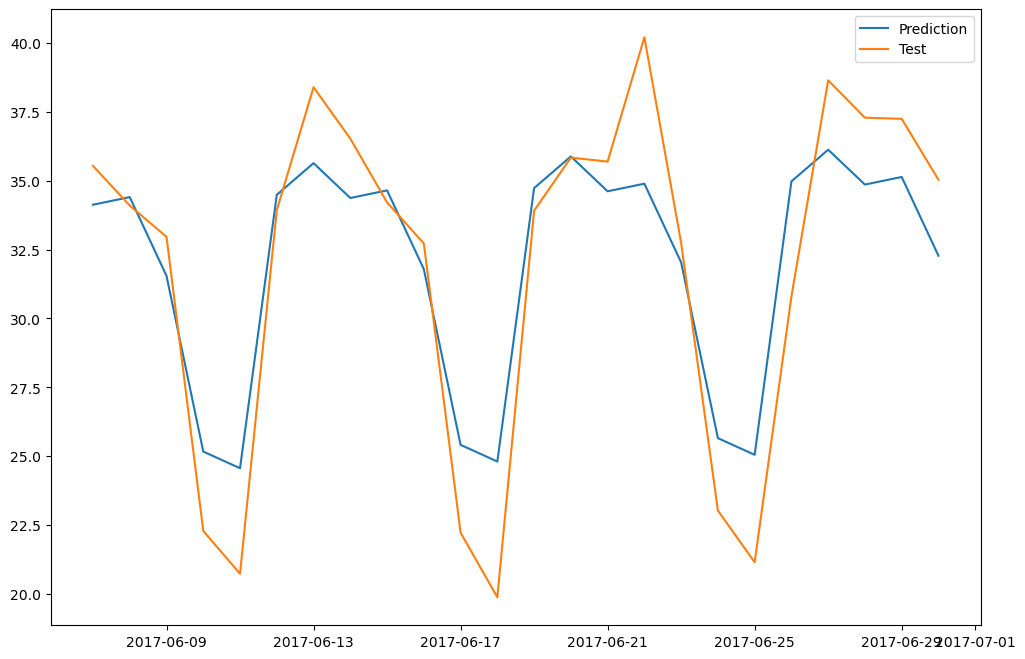

In [49]:
plt.figure(figsize=(12,8))
plt.plot(pd.date_range(start=test_set.index[0],periods=24),pred,label='Prediction')
plt.plot(pd.date_range(start=test_set.index[0],periods=24),test_set['traffic'],label='Test')
plt.legend()

* holt-winters seasonallity method 보다는 좀더 peak값을 반영이 됐음

In [50]:
from statsmodels.tools.eval_measures import rmse
score = rmse(test_set['traffic'],pred)
print(score,df['traffic'].std())

2.65600192464192 7.0063388757048575


* 약간의 성능향상이 일어남

# ARIMA

In [51]:
from pmdarima.arima import ndiffs

In [53]:
ndiffs(train_set)

1

In [62]:
model = auto_arima(train_set,d=1,trace=True,seasonal=True,stationary=False,m=7)
# seasonal = True 이고 m=1 이면 seasonal은 False로 바뀜

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[7] intercept   : AIC=inf, Time=1.09 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=3240.152, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=2732.787, Time=0.17 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=2999.197, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=3238.246, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[7] intercept   : AIC=3241.740, Time=0.06 sec
 ARIMA(1,1,0)(2,0,0)[7] intercept   : AIC=2613.034, Time=0.32 sec
 ARIMA(1,1,0)(2,0,1)[7] intercept   : AIC=2476.728, Time=0.74 sec
 ARIMA(1,1,0)(1,0,1)[7] intercept   : AIC=2474.728, Time=0.52 sec
 ARIMA(1,1,0)(0,0,1)[7] intercept   : AIC=3001.301, Time=0.21 sec
 ARIMA(1,1,0)(1,0,2)[7] intercept   : AIC=2476.728, Time=0.74 sec
 ARIMA(1,1,0)(0,0,2)[7] intercept   : AIC=2882.752, Time=0.34 sec
 ARIMA(1,1,0)(2,0,2)[7] intercept   : AIC=2478.715, Time=1.20 sec
 ARIMA(0,1,0)(1,0,1)[7] intercept   : AIC=2497.650, Time=0.38 sec
 ARIMA(2,1,0)(1,0,1)[7] intercept   : 

In [64]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                  584
Model:             SARIMAX(4, 1, 1)x(1, 0, 1, 7)   Log Likelihood               -1203.734
Date:                           Wed, 30 Nov 2022   AIC                           2425.468
Time:                                   19:15:18   BIC                           2464.782
Sample:                                        0   HQIC                          2440.792
                                           - 584                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    1.12e-05   3.32e-05      0.338      0.736   -5.38e-05    7.62e-05
ar.L1          0.6473      0.039     16.698      0.000       0.571       0.723
ar.L2          0.0447      0.053      0.850      0.395      -0.058       0.148
ar.L3          0.0531      0.050      1.067      0.286      -0.044       0.151
ar.L4         -0.0059      0.042     -0.141      0.888      -0.088       0.076
ma.L1         -0.9877      0.008   -128.469      0.000      -1.003      -0.973
ar.S.L7        0.9982      0.002    457.827      0.000       0.994       1.002
ma.S.L7       -0.9006      0.022    -40.254      0.000      -0.944      -0.857
sigma2         3.3131      0.148     22.454      0.000       3.024       3.602
===================================================================================
Ljung-Box (L1) (Q):                   0.15   Jarque-Bera (JB):               131.49
Prob(Q):                              0.69   Prob(JB):                         0.00
Heteroskedasticity (H):               1.42   Skew:                             0.47
Prob(H) (two-sided):                  0.01   Kurtosis:                         5.13
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Ljung-Box 검정의 귀무가설: 잔차가 백색잡음 시계열을 따른다

- 여기서는 신뢰수준이 0.88 이므로 유의수준 0.05 보다 크므로 귀무가설을 기각하지 못하고 따라서 백색잡음 시계열이다

Jaque-Bera(JB)의 귀무가설: 잔차가 정규성을 띤다

- 0.00 으로 유의수준0.05와 비교했을때 귀무가설을 기각한다 따라서 잔차가 정규성을 따르지 않음을 알 수 있다

Skew(비대칭도)는 0에 가까워야 하고 첨도는 3에 가까워야지 잔차가 정규분포를 따른다

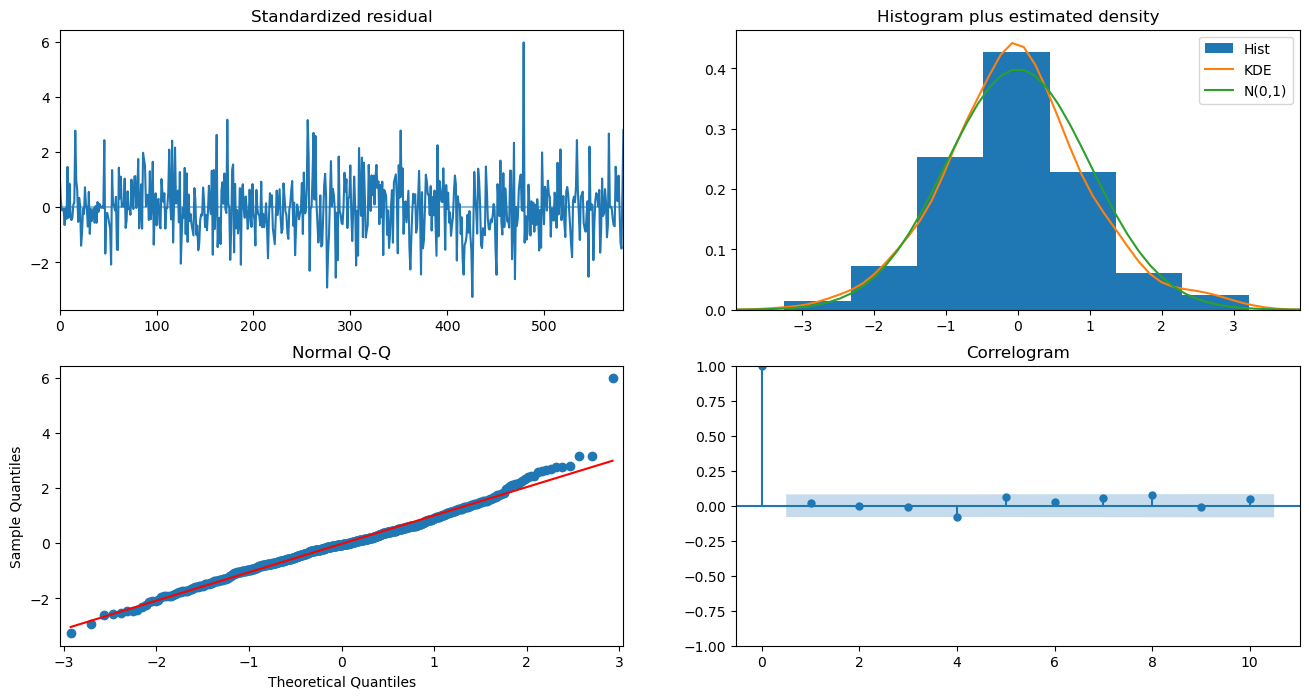

In [66]:
model.plot_diagnostics(figsize=(16,8));

In [68]:
# 테스트 데이터 예측
prediction = model.predict(n_periods=len(test_set))
pred_df = pd.DataFrame({'Prediction':prediction},index=test_set.index)

In [70]:
pred_df

,Prediction
DateTime,
2017-06-07,34.880598
2017-06-08,34.603525
2017-06-09,31.689102
2017-06-10,24.805066
2017-06-11,23.166450
2017-06-12,32.311541
2017-06-13,33.735961
2017-06-14,33.127306
2017-06-15,33.428271


<참고>
* subplots 연습하기

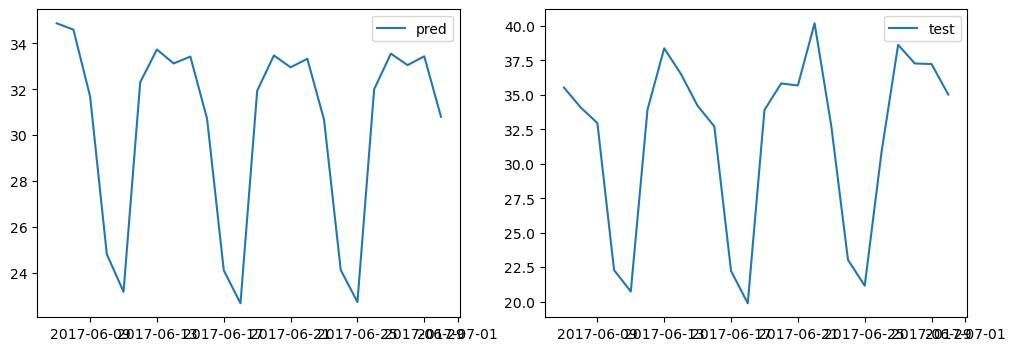

In [88]:
fig,axes = plt.subplots(1,2,figsize=(12,4))
axes[0].plot(pred_df,label='pred')
axes[1].plot(test_set,label='test')
axes[0].legend()
axes[1].legend()

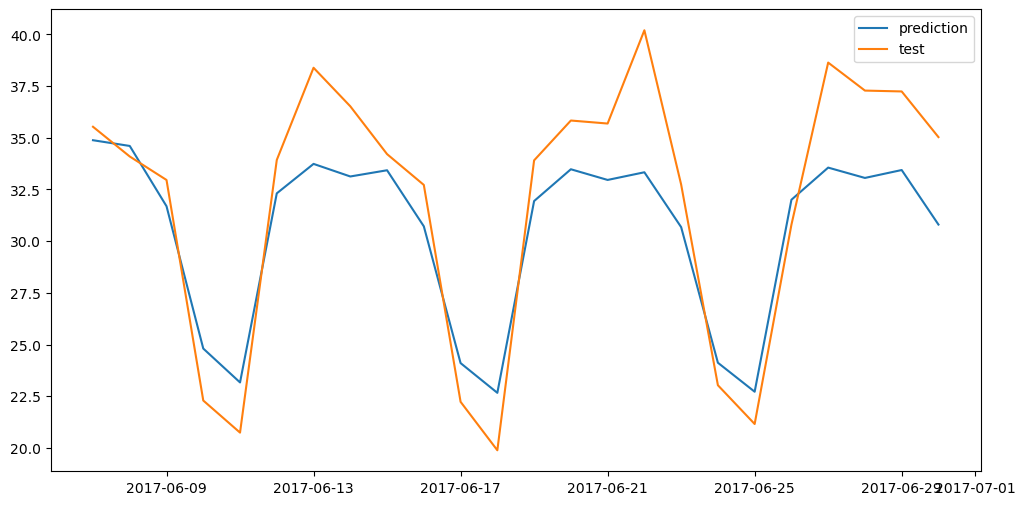

In [90]:
fig,axes = plt.subplots(1,1,figsize=(12,6))
axes.plot(pred_df,label='prediction')
axes.plot(test_set,label='test')
axes.legend()

위에 ETS모델보다 peak값을 잘 반영하지는 않지만 peak를 제외한 값들에 대해서는 성능 개선이 일어났다

In [98]:
print(type(np.array(test_set['traffic'])))
print(type(pred_df.values))
np.array(test_set['traffic'])

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


array([35.53125   , 34.09375   , 32.95833333, 22.29166667, 20.73958333,
       33.92708333, 38.38541667, 36.52083333, 34.20833333, 32.71875   ,
       22.22916667, 19.88541667, 33.90625   , 35.83333333, 35.6875    ,
       40.19791667, 32.73958333, 23.03125   , 21.15625   , 30.79166667,
       38.63541667, 37.28125   , 37.23958333, 35.03125   ])

In [103]:
from statsmodels.tools.eval_measures import rmse
score = rmse(test_set['traffic'],pred_df['Prediction'])
print(score,df['traffic'].std())

2.996017683894865 7.0063388757048575


# Conclusion
Clear한 seasonality를 갖고있는 데이터에 대해서 SARIMA와 Holt-Winters seasonality method,ETS method를 적용해 봤다 이결과<br>

ARIMA v.s Holt-winters : ARIMA가 Peak값과 그 주변 영역 이외에 값에 대해 좀더 잘 예측하는 결과를 나타냈다 하지만 Peak값을 비교적 underrated하여 rmse값은 Peak 값을 Peak값 주변 영역에서 전체적으로 좀더 높게 반영한 Holt-winters가 더 낮게 나왔다<br>

ARIMA v.s ETS: 마찬가지로 ARIMA 가 Peak값과 그 주변 영역 이외에 값에 대해 좀더 잘 예측하는 결과를 나타냈다 하지만 ETS는 꽤나 준수하게 주변 영역 이외에 값에 해당하는 부분을 잘 예측했고 Peak값에 대한 예측도 ARIMA보다 잘 수행해서 좋은 결과를 냈다
<br>
Phrophet의 RMSE는 비교가 안됨